In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

# Natural language processing libraries
#!pip install langdetect
#!pip install -U spacy
#!pip install empath
#!python -m spacy download en_core_web_sm

from langdetect import detect # for quotes language filtering
import nltk, spacy, sklearn
from spacy.lang.en import English
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
#nltk.download('punkt', quiet=True)
#nltk.download('stopwords', quiet=True)
#nltk.download('wordnet', quiet=True)

# Analysis of the lexical fields
from empath import Empath 

# PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import bz2
import json
import re
import pickle
import string

# the data file in github is data/
# the local data file is Data/
data_folder = './data/' 

### Simple explorations of the movie medadata

In [4]:
movies = pd.read_csv(data_folder + "movie.metadata.tsv", sep = '\t', names = ["WikiID","FreebaseID","Name", "Release_date", "Revenue",
"Runtime", "Languages","Countries", "Genres"])

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   WikiID        81741 non-null  int64  
 1   FreebaseID    81741 non-null  object 
 2   Name          81741 non-null  object 
 3   Release_date  74839 non-null  object 
 4   Revenue       8401 non-null   float64
 5   Runtime       61291 non-null  float64
 6   Languages     81741 non-null  object 
 7   Countries     81741 non-null  object 
 8   Genres        81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [6]:
# Looking at the time span of the movies.
from datetime import datetime, date, time
mv_yr = movies.Release_date.dropna().apply(lambda x: x)
print(movies.Release_date.dropna().iloc[57571])
print(movies[movies.Release_date == "1010-12-02"])

yrs = []
cnt = 0
for yr in mv_yr:
    k = int(yr[0:4])
    if k == 1010:
        print(cnt)
    cnt = cnt + 1
    yrs.append(k)

np.sort(yrs)

# Interesting discovery. 
# The movie 'Hunting Season' is acutally out on 2010.


1010-12-02
         WikiID  FreebaseID            Name Release_date     Revenue  Runtime  \
62836  29666067  /m/0fphzrf  Hunting Season   1010-12-02  12160978.0    140.0   

                                               Languages  \
62836  {"/m/02hwyss": "Turkish Language", "/m/02h40lc...   

                     Countries  \
62836  {"/m/01znc_": "Turkey"}   

                                                  Genres  
62836  {"/m/0lsxr": "Crime Fiction", "/m/02n4kr": "My...  
57571


array([1010, 1888, 1889, ..., 2016, 2016, 2016])

In [41]:
# As we have seen from the previous block, the release time for 'Hunting Season' is wrong. We hereby crorrect this mistake.
movies['Release_date'] = movies['Release_date'].replace(['1010-12-02'], '2010-12-02')

In [7]:
movies[movies.Runtime == 2880]

,WikiID,FreebaseID,Name,Release_date,Revenue,Runtime,Languages,Countries,Genres
68223,884492,/m/03lm_0,The Longest Most Meaningless Movie in the World,1968,NaN,2880.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0424mc"": ""Experimental film""}"


count    58626.000000
mean        93.695856
std         43.118155
min          0.000000
25%         81.000000
50%         93.000000
75%        107.000000
max       2880.000000
Name: Runtime, dtype: float64


<AxesSubplot:ylabel='Runtime'>

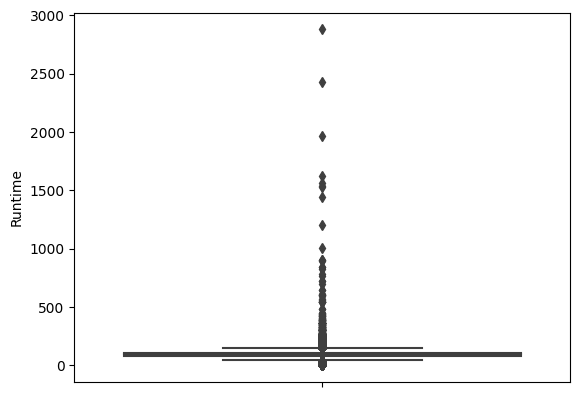

In [8]:
#Looking at the runtime of movies
import seaborn as sns
mv_yr_runtime = movies[["Release_date","Runtime"]].dropna()
mv_yr_runtime['re_yr'] = mv_yr_runtime.Release_date.apply(lambda x: int(x[0:4]))
print(mv_yr_runtime[mv_yr_runtime.Runtime<3000].Runtime.describe())

sns.boxplot(y = "Runtime", data = mv_yr_runtime[mv_yr_runtime.Runtime < 3000])
#mv_yr_runtime[mv_yr_runtime.re_yr == 1010]['re_yr'] = 2020
#plt.scatter(x = mv_yr_runtime.re_yr, y = mv_yr_runtime.Runtime, vmin = 1, vmax = 500)

<AxesSubplot:xlabel='Runtime', ylabel='Density'>

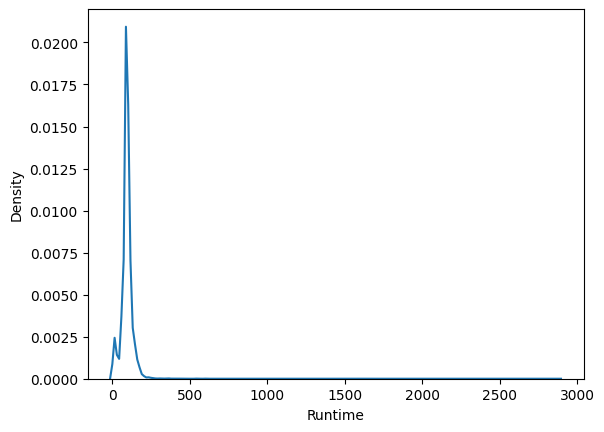

In [9]:
sns.kdeplot(mv_yr_runtime[mv_yr_runtime.Runtime<3000].Runtime)

<AxesSubplot:xlabel='re_yr', ylabel='Runtime'>

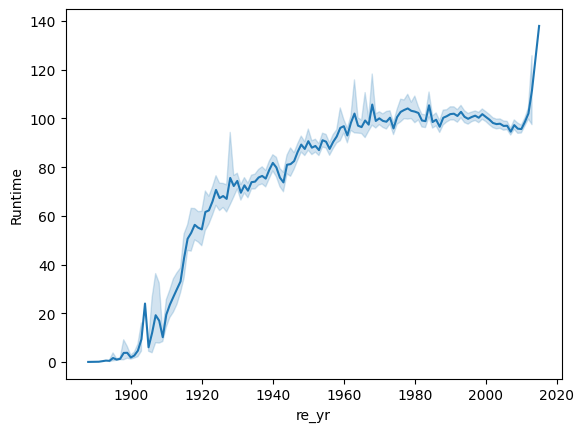

In [108]:
sns.lineplot(data = mv_yr_runtime[(mv_yr_runtime.Runtime<3000) & (mv_yr_runtime.re_yr>1200)], x = "re_yr", y = "Runtime", legend = "full")

### Explorations of the character data

In [10]:
characters = pd.read_csv(data_folder + "character.metadata.tsv", sep = '\t', names = ["WikiID", "FreebaseID", "Release_date",
"Character_name",
"Actor_date_of_birth",
"Actor_gender",
"Actor_height",
"Actor_ethnicity",
"Actor_name",
"Actor_age_at_movie_release",
"map_ID",
"character_ID",
"actor_ID"])

In [11]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   WikiID                      450669 non-null  int64  
 1   FreebaseID                  450669 non-null  object 
 2   Release_date                440674 non-null  object 
 3   Character_name              192794 non-null  object 
 4   Actor_date_of_birth         344524 non-null  object 
 5   Actor_gender                405060 non-null  object 
 6   Actor_height                154824 non-null  float64
 7   Actor_ethnicity             106058 non-null  object 
 8   Actor_name                  449441 non-null  object 
 9   Actor_age_at_movie_release  292556 non-null  float64
 10  map_ID                      450669 non-null  object 
 11  character_ID                192804 non-null  object 
 12  actor_ID                    449854 non-null  object 
dtypes: float64(2),

In [12]:
# It is possible that, the same character will appear in different movies.
characters[characters.Character_name == "Robin Hood"]

,WikiID,FreebaseID,Release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,map_ID,character_ID,actor_ID
54984,556241,/m/02pp19,1993-07-28,Robin Hood,1962-10-26,M,1.83,/m/0152s7,Cary Elwes,30.0,/m/0k2m26,/m/06j7x,/m/0219q
115117,723582,/m/035t7n,1952-06-26,Robin Hood,1919-06-11,M,NaN,NaN,Richard Todd,33.0,/m/02tbhw6,/m/06j7x,/m/0147bj
160468,2071706,/m/06k5xq,1976-03-11,Robin Hood,1930-08-25,M,1.89,/m/03lmx1,Sean Connery,45.0,/m/0k2lw_,/m/06j7x,/m/06mr6
195730,62084,/m/0gssy,1938,Robin Hood,1909-06-20,M,1.88,/m/033tf_,Errol Flynn,28.0,/m/0k48xm,/m/0gz66n0,/m/0hnp7
347655,982180,/m/03wh1s,1973-11-08,Robin Hood,1935-02-16,M,NaN,NaN,Brian Bedford,38.0,/m/0k2m0f,/m/05yxn25,/m/0bmr4f
361719,3370990,/m/0983nh,1949,Robin Hood,1909-06-20,M,1.88,/m/033tf_,Errol Flynn,39.0,/m/09l3pqd,/m/0gz66hf,/m/0hnp7
374250,261402,/m/01msrb,1991-06-14,Robin Hood,1955-01-18,M,1.85,/m/09vc4s,Kevin Costner,36.0,/m/0k2m4s,/m/06j7x,/m/0127m7
422419,157172,/m/014nbs,1981-07-13,Robin Hood,1939-10-27,M,1.96,/m/02w7gg,John Cleese,41.0,/m/0k74q8,/m/06j7x,/m/041c4


In [51]:
len(characters.WikiID.unique())

64330

### Will merging the movies df and the characters df be helpful?

In [42]:
movie_char = pd.merge(movies, characters, left_on = "WikiID", right_on = "WikiID")
print(len(movie_char.WikiID.unique()))

64330


In [43]:
# We are dealing with the sex stats, thus the NA values of actor genders are not helpful. 
# Here we remove columns with NA actor_gender values.
movie_char = movie_char.dropna(subset = ['Actor_gender'])

In [44]:
# transforming the sex data into a more flexible format.
movie_char['MaleActor'] = (movie_char.Actor_gender == 'M').astype(int)
movie_char['FemaleActor'] = (movie_char.Actor_gender == 'F').astype(int)

In [45]:
# Grouping by the data by films. In each grouped dataframe, summing the sex stats of male and female, we get the gender sum of each flim.
movie_char_GpBy = movie_char.groupby(by = 'WikiID')

In [49]:
SexStats = movie_char_GpBy.apply(lambda x: x[['MaleActor', 'FemaleActor']].sum())

In [50]:
SexStats = SexStats.rename(columns={'MaleActor': 'MaleCount', 'FemaleActor': 'FemaleCount'})

In [51]:
SexStats

,MaleCount,FemaleCount
WikiID,,
330,0,4
3217,10,3
3333,8,6
3746,11,3
3837,18,2
...,...,...
37322106,1,2
37373877,3,3
37476824,6,4


In [53]:
movie_gender = pd.merge(movies, SexStats, left_on = "WikiID", right_index = True)

We have counted the apprearence of male, female actors in each film, and stored them in the column: '__MaleCount__', '__FemaleCount__'

__Please also note that:__ the result is derived after removing the rows with the 'Actor_gender' being NA.

In [54]:
movie_gender

,WikiID,FreebaseID,Name,Release_date,Revenue,Runtime,Languages,Countries,Genres,MaleCount,FemaleCount
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",11,6
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",11,4
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2,2
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1,1
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",2,1
...,...,...,...,...,...,...,...,...,...,...,...
81733,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",7,4
81735,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,132.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/06bnz"": ""Russia""}","{""/m/01z02hx"": ""Sports"", ""/m/0lsxr"": ""Crime Fi...",6,1
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",2,0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",10,5


In [85]:
# We want to see how the difference of Male, Female actors numbers change over time.

# We are dealing with time, so NA time for us is not useful. We drop rows with NA release_date values
movie_gender = movie_gender.dropna(subset = ['Release_date'])

# We only care about the year time, so we cut the year from the Release_data column, and place the year at column 'Release_year'
movie_gender['Release_year'] = movie_gender.Release_date.apply(lambda x: str(x)[0:4])

# Derive the male--female difference
movie_gender['SexDiff'] = movie_gender.MaleCount - movie_gender.FemaleCount

# Sorting by time
movie_gender =  movie_gender.sort_values(by = 'Release_year').copy() 

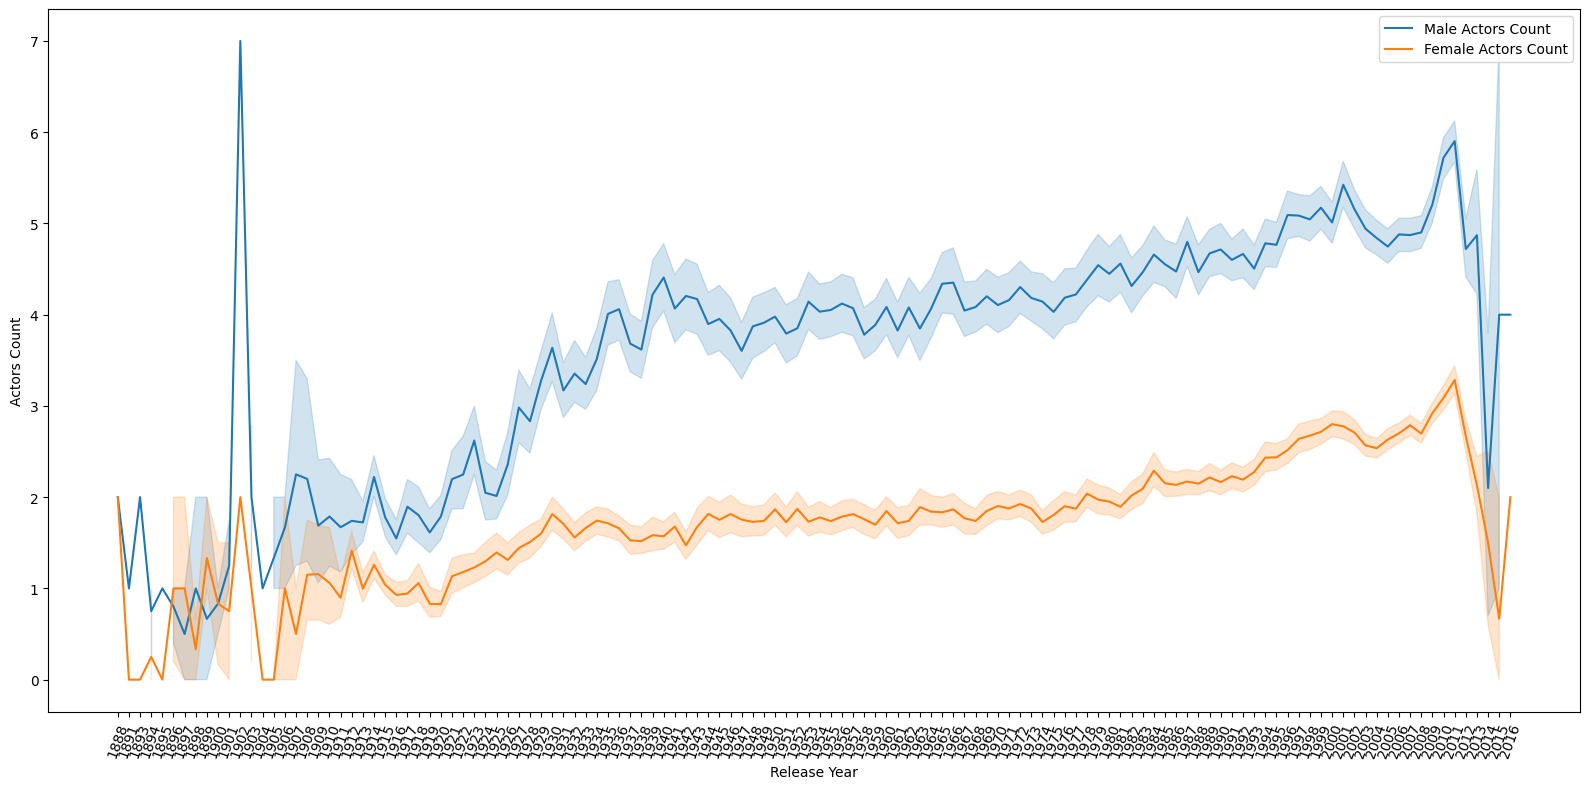

In [87]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(data = movie_gender, x = 'Release_year', y = 'MaleCount', legend = "full", label = "Male Actors Count")
ax = sns.lineplot(data = movie_gender, x = 'Release_year', y = 'FemaleCount', legend = "full", label = "Female Actors Count")
#ax = sns.lineplot(data = movie_gender, x = 'Release_year', y = 'SexDiff', legend = "full", label = "SexDiff")
ax.set_xticks(np.unique(movie_gender.Release_year.values))
ax.set_xticklabels(np.unique(movie_gender.Release_year.values), rotation=70)
plt.xlabel("Release Year")
plt.ylabel("Actors Count")
plt.tight_layout()
plt.show()

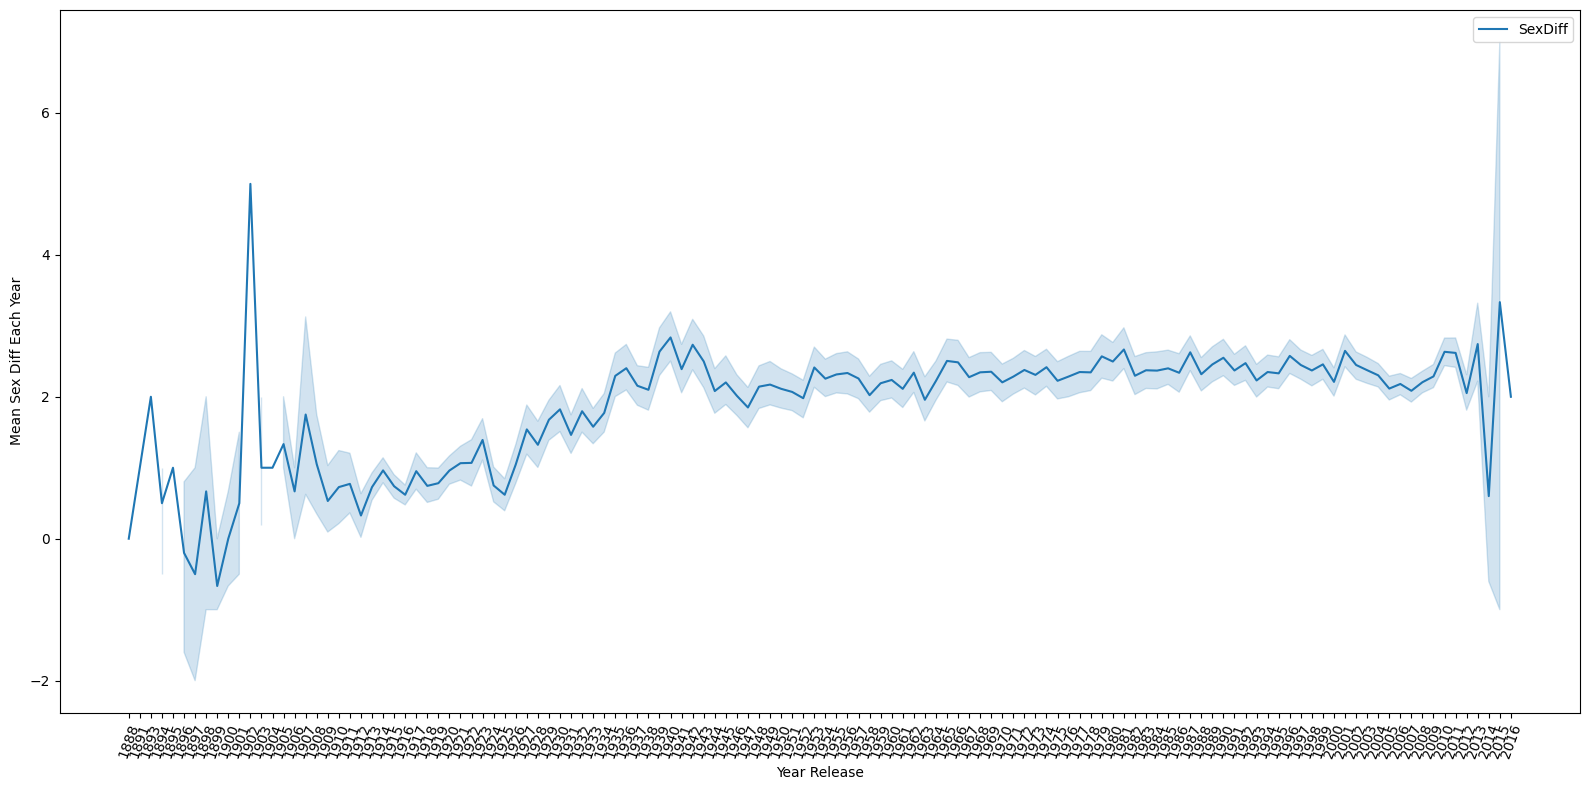

In [88]:
plt.figure(figsize = (16,8))
ax = sns.lineplot(data = movie_gender, x = 'Release_year', y = 'SexDiff', legend = "full", label = "SexDiff")
ax.set_xticks(np.unique(movie_gender.Release_year.values))
ax.set_xticklabels(np.unique(movie_gender.Release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Mean Sex Diff Each Year")
plt.tight_layout()
plt.show()

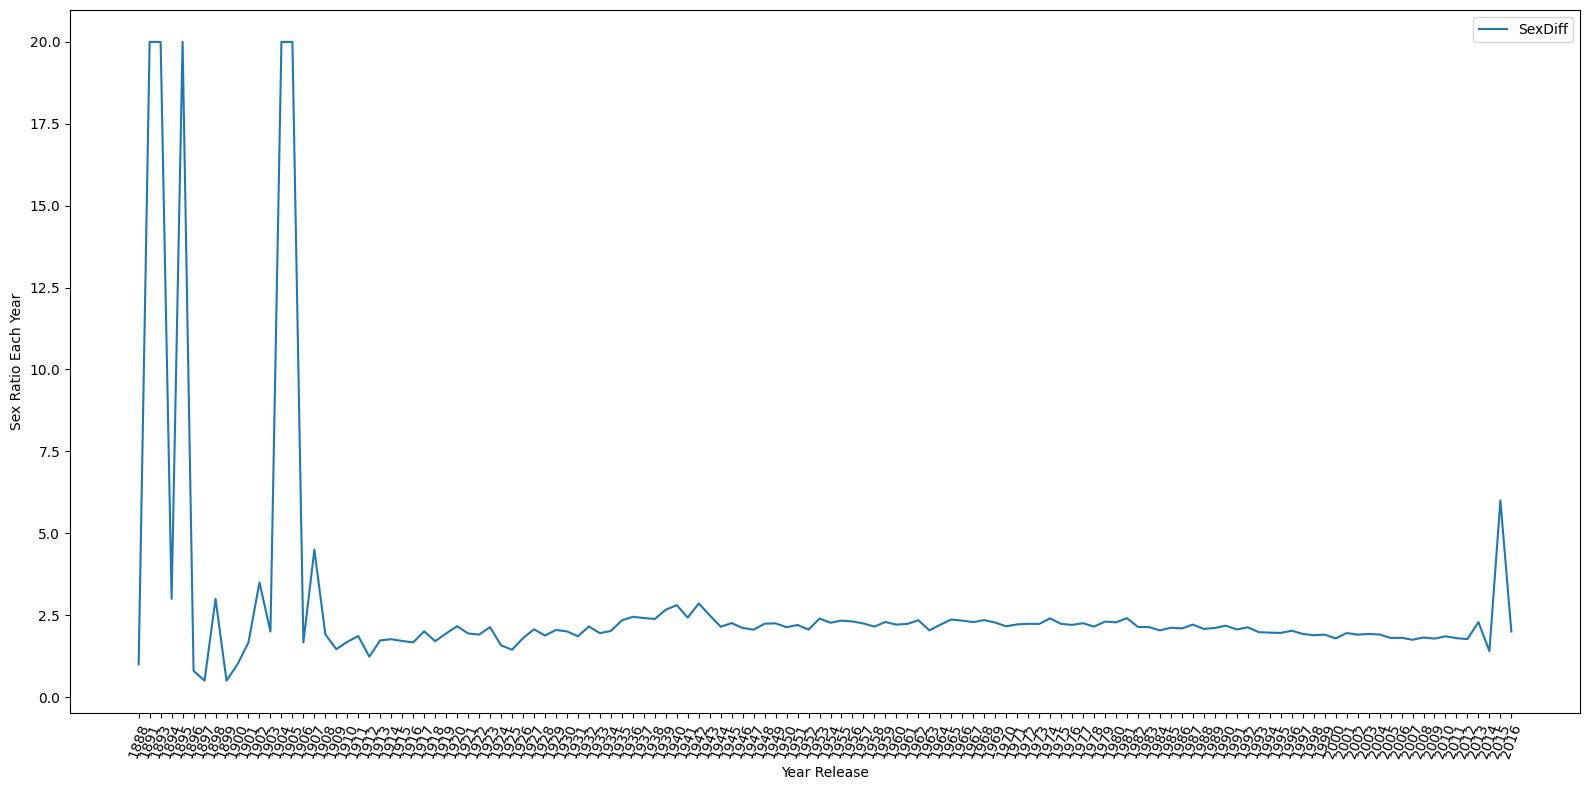

In [108]:
movie_gender_GpBy_time = movie_gender.groupby(by = 'Release_year')
male_count_year = movie_gender_GpBy_time.apply(lambda x: x.MaleCount.sum())
female_count_year = female_sum = movie_gender_GpBy_time.apply(lambda x: x.FemaleCount.sum())
sex_ratio = male_count_year / female_count_year

# For years when we obtain inf ratio (usually because of little sample), we set the inf value to be a large value (20)
sex_ratio.replace([np.inf, -np.inf], 20, inplace=True)

sex_ratio = pd.DataFrame(sex_ratio, columns = ['M/F_ratio']).reset_index()

# Plotting
plt.figure(figsize = (16,8))
ax = sns.lineplot(data = sex_ratio, x = 'Release_year', y = 'M/F_ratio', legend = "full", label = "SexDiff")
ax.set_xticks(np.unique(sex_ratio.Release_year.values))
ax.set_xticklabels(np.unique(sex_ratio.Release_year.values), rotation=70)
plt.xlabel("Year Release")
plt.ylabel("Sex Ratio Each Year")
plt.tight_layout()
plt.show()